<a href="https://colab.research.google.com/github/Shubhamd13/NLP/blob/main/5_1_Encoder_Decoder_Student_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utility

In [2]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
np.random.seed(888) # Fixed random seed for reproducibility

## Task

Let's assume that we are training a Transformer for English to French Translation Task. For simplicity, we will consider only one forward pass.

Let's say we have the following two sentences:

$\text{English Text: "I am student"}$

$\text{French Text: "Je suis étudiant"}$

So, the encoder will take the English tokens as input. The decoder will take the French Tokens one by one and learn using next word prediction objective.


## Vocabulary (Do not change)

In [3]:
# Vocabulary dictionary
vocab = {"I":1, "étudiant":3, "student":5, "am":0, "Je":2, "suis":4, "<EOS>": 6, "<START>": 7}

vocab_size = len(vocab)
embed_dim = 2

# Static Embedding matrix for Vocabulary
np.random.seed(888)
static_embedding_matrix = np.random.rand(vocab_size, embed_dim)

# Show embeddings of each word in the vocabulary
print("Embedding of each word in vocab\n")
for obj in vocab:
  print(obj, " = ", static_embedding_matrix[vocab[obj]])

Embedding of each word in vocab

I  =  [0.483 0.921]
étudiant  =  [0.925 0.658]
student  =  [0.899 0.248]
am  =  [0.86  0.165]
Je  =  [0.429 0.057]
suis  =  [0.133 0.533]
<EOS>  =  [0.03  0.072]
<START>  =  [0.874 0.558]


## Transformer Encoder

To keep things simple, we will use a basic encoder architecture that follows this flow:

$
\text{Input Embedding} \rightarrow \text{Self-Attention} \rightarrow \text{Residual connection + Layer norm} \rightarrow \text{Encoder output}
$

We are skipping some of the usual components like MLP layers for simplicity.

$\text{Step 1: Input Embedding, $Inp_{emb}\;(Do \; not \; change)$}$

Get indexes of input words from the vocab and use the indexes to get embedding from the static embedding matrix

In [4]:
# ----- Step 0: encoder input tokens -----
encoder_input = ["I", "am", "student"]

# ----- Step 1: Encoder Input Embedding -----
encoder_input_embed = np.array([static_embedding_matrix[vocab[token]] for token in encoder_input])
print("Encoder input embeddings:\n\n", encoder_input_embed)

Encoder input embeddings:

 [[0.483 0.921]
 [0.86  0.165]
 [0.899 0.248]]


$\text{Step 2: Self Attention}$

$$Query, Q = X W_Q, \quad Key, K = X W_K, \quad Value, V = X W_V$$

$$\text{Scaled Attention Scores} = \frac{Q K^T}{\sqrt{d}}$$

$$
\text{Attention Output, $X_{attn}$} = \text{Softmax}\left( \frac{Q K^T}{\sqrt{d}} \right) \cdot V$$

In [5]:
# ----- Step 2. Encoder Self-Attention -----
# Weight matrices for attention
np.random.seed(888)
W_q_enc = np.random.rand(embed_dim, embed_dim)
W_k_enc = np.random.rand(embed_dim, embed_dim)
W_v_enc = np.random.rand(embed_dim, embed_dim)

# Calculate Q, K, V
Q_enc = encoder_input_embed @ W_q_enc
K_enc = encoder_input_embed @ W_k_enc
V_enc = encoder_input_embed @ W_v_enc

# Calculate Scaled Attention Scores
scaled_attention_scores = Q_enc @ K_enc.T / np.sqrt(K_enc.shape[1])
print("Scaled Attention Scores:\n", scaled_attention_scores)
print("="*50)

# Apply Softmax
attention_weights = np.exp(scaled_attention_scores) / np.sum(np.exp(scaled_attention_scores), axis=-1, keepdims=True)

# Attention Output

###<--- Write code here
attention_output = attention_weights@ V_enc     # wighted sum of values after softmax
###

print("Attention Output:\n", attention_output)
print("="*50)

Scaled Attention Scores:
 [[1.06  0.42  0.516]
 [0.744 0.334 0.401]
 [0.838 0.371 0.446]]
Attention Output:
 [[0.584 0.505]
 [0.552 0.507]
 [0.56  0.506]]


$\text{Step 3: Residual Connection}\;(Do \; not \; change)$

$ Z_{residual} = X_{attn}+Inp_{emb}$


In [6]:
# ----- Step 3. Residual Connection -----
residual_connect = attention_output + encoder_input_embed
print("Residual connection:\n\n", residual_connect)

Residual connection:

 [[1.067 1.426]
 [1.412 0.671]
 [1.459 0.755]]


$\text{Step 4: Layer Normalization}$

$$
N(x) = \frac{x - \mu}{\alpha}
$$

$$
\mu = \frac{1}{H} \sum_{i=1}^{H} X_i
$$

$$
\alpha = \sqrt{ \frac{1}{H} \sum_{i=1}^{H} (x_i - \mu)^2 }
$$

Where:

- \( x \) = Vector representation of inputs  
- \( H \) = Number of inputs  
- \( \mu \) = Mean of inputs  
- \( \alpha \) = Standard deviation of inputs

In [7]:
# ----- Step 4. LayerNorm -----

def layer_norm(x):

    ###<-- Write your code here
    mean = np.mean(x, axis=1, keepdims=True)                    ## average across row
    ###

    variance = np.var(x, axis=1, keepdims=True)
    return (x - mean) / np.sqrt(variance)

encoder_output = layer_norm(residual_connect)
print("Encoder Output (used for K, V in Decoder):\n", encoder_output)

Encoder Output (used for K, V in Decoder):
 [[-1.  1.]
 [ 1. -1.]
 [ 1. -1.]]


## Transformer Decoder

To keep things simple, we will use a basic encoder architecture that follows this flow:

$
\text{Input Embedding} \rightarrow \text{Cross-Attention} \rightarrow \text{Linear Projection to Vocabulary} \rightarrow \text{Loss Calculation}
$

We are skipping some of the usual components like MLP layers, Self-Attention, Residual Connection + Layer Normalization for simplicity.

$\text{Step 1: Decoder Input Embedding, $Inp_{emb} \;(Do \; not \; change)$}$

Get indexes of input words from the vocab and use the indexes to get embedding from the static embedding matrix

In [8]:
# ----- Step 0. Decoder input and target tokens -----
decoder_input_tokens = ["<START>", "Je", "suis", "étudiant"]
seq_len = len(decoder_input_tokens)  # length of input sequence
target_tokens = ["Je", "suis", "étudiant", "<EOS>"]

# ----- Step 1. Decoder Input Embedding -----
decoder_input_embed = np.array([static_embedding_matrix[vocab[token]] for token in decoder_input_tokens])
print("\nDecoder input embeddings:\n", decoder_input_embed)


Decoder input embeddings:
 [[0.874 0.558]
 [0.429 0.057]
 [0.133 0.533]
 [0.925 0.658]]


$\text{Step 2: Cross Attention}$

$$\textbf{(a) Query, Key, and Value Computation:}$$

$$Q = Decoder_{input}\; W_Q, \quad K = Encoder_{output} \; W_K, \quad V = Encoder_{output} \;W_V$$

$$\textbf{(b) Scaled Attention Scores:}$$

$$\text{Attention Scores} = \frac{Q K^T}{\sqrt{d}}$$

$$\textbf{(c) Softmax:}$$

$$\text{Attention Weights} = \text{Softmax}(\text{Attention Scores})$$

$$\textbf{(d) Weighted Sum of Values:}$$

$$\text{Attention Output} = \text{Attention Weights} * V$$

$$\textbf{Final Formula:}$$

$$
\text{Attention Output} = \text{Softmax}\left( \frac{Q K^T}{\sqrt{d}} \right) V$$


Where:

- \( x \) = Vector representation of inputs  
- \( H \) = Number of inputs  
- \( \mu \) = Mean of inputs  
- \( \alpha \) = Standard deviation of inputs

In [10]:
# ----- Step 2. Decoder Cross-Attention -----

# Cross-Attention weight matrices for decoder
np.random.seed(888)
W_q_dec = np.random.rand(decoder_input_embed.shape[1], decoder_input_embed.shape[0])
W_k_dec = np.random.rand(decoder_input_embed.shape[1], decoder_input_embed.shape[0])
W_v_dec = np.random.rand(decoder_input_embed.shape[1], decoder_input_embed.shape[0])

# (a) Calculate Q, K, V for decoder
Q_dec = decoder_input_embed @ W_q_dec
K_dec = encoder_output @ W_k_dec  # Projecting encoder output to K
V_dec = encoder_output @ W_v_dec  # Projecting encoder output to V

# (b) Scaled Cross-Attention Scores

###<-- Write your code here
scores_dec =   Q_dec @ K_dec.T /   np.sqrt(K_dec.shape[1])              ## QK^T/root(dk)
###

print("Cross Attention Scores:\n\n", np.array(scores_dec))
print("="*50)

# (c) Softmax
attention_weights_dec = np.exp(scores_dec) / np.sum(np.exp(scores_dec), axis=-1, keepdims=True)

# (d) Attention Output
decoder_output = attention_weights_dec @ V_dec

print("Decoder Cross-Attention Output:\n", decoder_output)

print(f"{Q_dec.shape}")

Cross Attention Scores:

 [[ 0.078 -0.078 -0.078]
 [ 0.027 -0.027 -0.027]
 [ 0.037 -0.037 -0.037]
 [ 0.087 -0.087 -0.087]]
Decoder Cross-Attention Output:
 [[ 0.216  0.068 -0.017 -0.089]
 [ 0.255  0.081 -0.02  -0.105]
 [ 0.247  0.078 -0.019 -0.102]
 [ 0.209  0.066 -0.016 -0.086]]
(4, 4)


$\text{Step 3. Linear Projection to Vocabulary }\;(Do \; not \; change)$

For simplicity, here we assume that the decoder output is the cross attention output.

Assume we have a weight matrix for the linear layer: $𝑊_{out} ∈ 𝑅^{4×8}$ → here, embedding size = 4 and vocab size = 8

$logits = \text{decoder}_{output} \; W_{out} $

In [11]:
# ----- Step 3. Linear Projection to Vocabulary -----

W_out = np.random.rand(decoder_output.shape[0], vocab_size)
logits = decoder_output @ W_out

print("Logits:\n", logits)

Logits:
 [[ 0.142  0.013  0.047  0.055 -0.025  0.053  0.015  0.053]
 [ 0.168  0.015  0.056  0.065 -0.029  0.063  0.018  0.063]
 [ 0.163  0.014  0.054  0.063 -0.028  0.061  0.018  0.061]
 [ 0.138  0.012  0.046  0.053 -0.024  0.052  0.015  0.052]]


$\text{Step 4. Loss Calculation}$

If we are doing cross-entropy loss for predicting over 5 words (assume the vocabulary size is 5), the cross-entropy loss for a single prediction is -  


$\mathcal{L} = - \sum_{i=1}^{5} y_{i}\log(\hat{y}_{i})$

Here,

$y_{i}$ = 1 if word $i$ is the true label otherwise 0

$\hat{y}_{i}$ =  model’s predicted probability for word $i$

Because only one $y_{i}$ is 1 (true label), this simplifies to -

$\mathcal{L} = - \log(\hat{y})$

In [12]:
# ----- Step 4. Loss Calculation -----
target_indices = [vocab[token] for token in target_tokens]
input_indices  = np.arange(len(target_indices))

# Cross Entropy Loss
def cross_entropy(pred_logits, target_index):
    exp_logits = np.exp(pred_logits)


    ###<-- Write your code here
    probs =   exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)               # complete softmax
    ###

    log_prob = -np.log(probs[target_index])
    return log_prob, probs


losses = []
all_pred_probs = []
all_gold_onehots = []

for i in range(seq_len):
    loss, pred_probs = cross_entropy(logits[i], target_indices[i])

    # store gold label and predicted probability distribution
    all_pred_probs.append(pred_probs)
    gold_one_hot_vec = np.zeros_like(pred_probs)
    gold_one_hot_vec[target_indices[i]] = 1.0
    all_gold_onehots.append(gold_one_hot_vec)

    print(f"Token: '{decoder_input_tokens[i]}' → Target: '{target_tokens[i]}', Loss: {round(loss, 4)}")
    losses.append(loss)

total_avg_loss = sum(losses) / len(losses)
print("\nAverage Loss:", round(total_avg_loss, 4))

Token: '<START>' → Target: 'Je', Loss: 2.0775
Token: 'Je' → Target: 'suis', Loss: 2.1623
Token: 'suis' → Target: 'étudiant', Loss: 2.0685
Token: 'étudiant' → Target: '<EOS>', Loss: 2.1085

Average Loss: 2.1042


## Plot distribution of model prediction vs gold label (Do not change)


Model Prediction Probability over vocabulary for token "<START>":  [0.138 0.121 0.125 0.126 0.117 0.126 0.121 0.126]



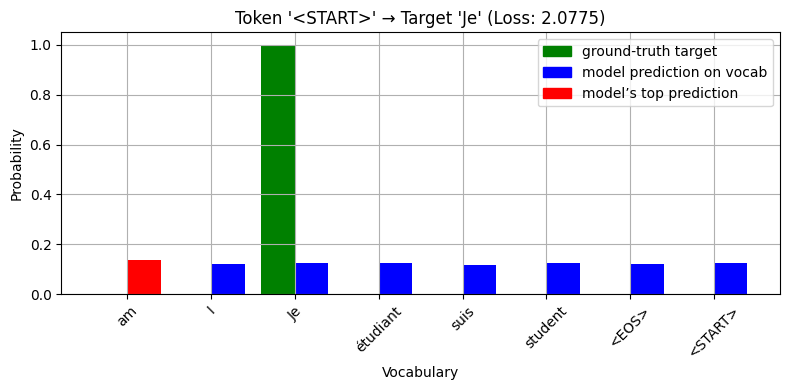


Model Prediction Probability over vocabulary for token "Je":  [0.14  0.12  0.125 0.126 0.115 0.126 0.121 0.126]



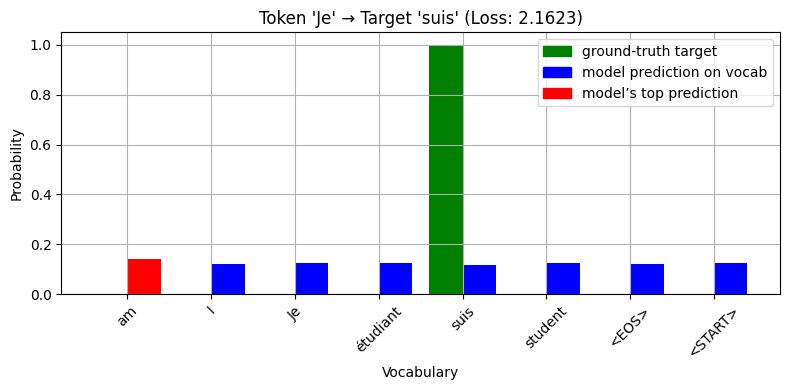


Model Prediction Probability over vocabulary for token "suis":  [0.14  0.12  0.125 0.126 0.115 0.126 0.121 0.126]



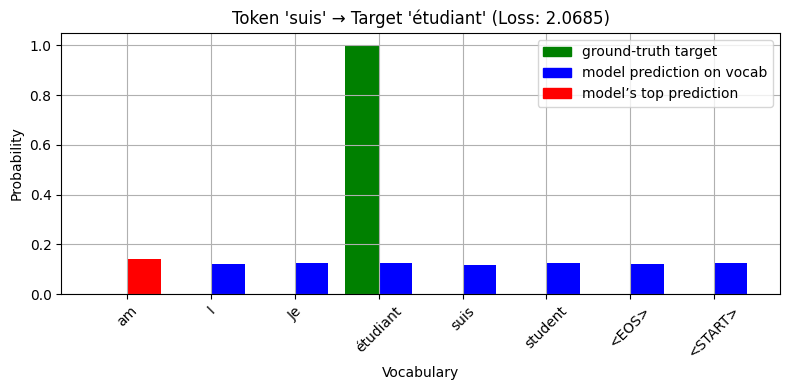


Model Prediction Probability over vocabulary for token "étudiant":  [0.137 0.121 0.125 0.126 0.117 0.126 0.121 0.126]



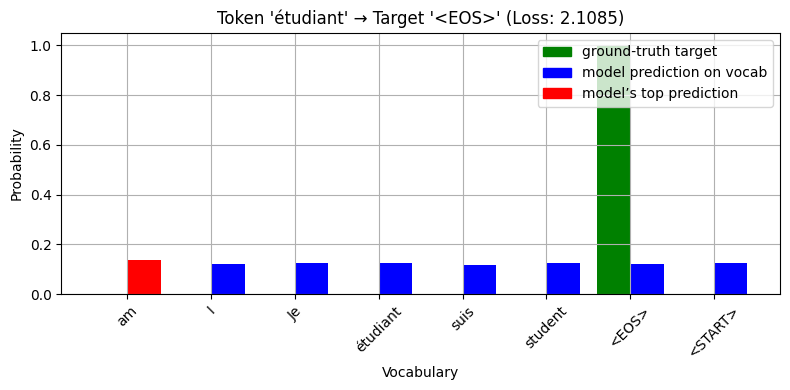

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vocab_inv = {v: k for k, v in vocab.items()}

for i in range(seq_len):
    plt.figure(figsize=(8, 4))
    vocab_labels = [vocab_inv[j] for j in range(len(vocab))]
    x = np.arange(len(all_pred_probs[i]))

    # Plot gold labels as green
    plt.bar(x - 0.2, all_gold_onehots[i], width=0.4, label="Gold One-Hot", color="green")

    highest_idx = np.argmax(all_pred_probs[i])

    # Set red for highest prediction, blue for others
    colors = ["blue"] * len(all_pred_probs[i])
    colors[highest_idx] = "red"

    # Plot model prediction with red/green colors
    plt.bar(x + 0.2, all_pred_probs[i], width=0.4, label="Model Prediction", color=colors)

    plt.xticks(x, vocab_labels, rotation=45)
    plt.title(f"Token '{decoder_input_tokens[i]}' → Target '{target_tokens[i]}' (Loss: {round(losses[i], 4)})")
    plt.xlabel("Vocabulary")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True)

    green_patch = mpatches.Patch(color='green', label='ground-truth target')
    blue_patch = mpatches.Patch(color='blue', label='model prediction on vocab')
    red_patch = mpatches.Patch(color='red', label='model’s top prediction')

    plt.legend(handles=[green_patch, blue_patch, red_patch], loc='upper right')

    print(f"\nModel Prediction Probability over vocabulary for token \"{decoder_input_tokens[i]}\": ", all_pred_probs[i])
    print("")

    plt.tight_layout()
    plt.show()